## title

This code is a colaboration between Josh Broomberg and I. We have decided to apply greedy and dynamic programing solution to the navigation problem.

The lack of time to explore and the cold termperatures on top of the desire to implement new algorithms led to the decision to submit the assignemnt as is. 

### Navigation  program ###

We have converted a picture of the Gangnam area taken from Google maps to a 2D matrix. The matrix ``` raw_data ``` is a 3D array that holds the RGB values for each pixel in the map. The ```weight_matrix``` is a 2D matrix of the same size which holds the cost of travel per pixel. The weihts are assigned based on a manual inspection of their colors in the map; where possible transportation methods are either on roads (by foot, car, or bus) or via metro lines. Each road was colored black and weighted based on a the estimated of travelling time. roads cost is 4, and metro cost is 2 (considering traffic or walking versus metro fixed time scheduele). We set out navigation goal fron Itewon, on the top left corner of the map, to the left right corner .

**The greedy algorithm works as follows:**
Each pixel is a decision point. The decision is always to choose the least cotly next pixel. The cost of each step is computed using a ```heuristic``` function that adjust for the geometric direct distance to the goal. The execution function chooses between all possible neighbors the one with the combined smaller cost. The greedy property in this situation is not proven and likely to result in less than optimal path. It's avarge complexity is $O(Cp)$ where C is the mean number of neighbors and p is the expected path length. The worst case complexity is O(N^2) where N is the size of the matrix (in case of vising every pixel in the map; the algorithm does not allow backtracj hence limited by the size of the map).

**A dynamic programing solution **
A second implimentation is of A start algorithm in the fucntion ```a_star```. This is a variation on dijkstra algorithm. It is optimized to move between a known origin to a known destination by (1) adding a heuristic computation to the simple cheapest neighbor, advancing the path to the gegneral direction of the goal and (2) it stops as soon as the goal was reached. This algorithm runs in a higher complexity to this of the greedy algorithm; $O(C^p)$ where C is the number of neighbors to check (bounded by 8) and p is the expected shortest path. In this case, the complexiy is factorial. 


The dynamic programing function, as expected, ran for much longer than the greedy function. (many minutes versus few miliseconds) yet results in a lower scored, more optimized, result ( about three times more costly for the greedy algorithm).

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import copy
import heapq

In [2]:
# Read the image file and create an array based on the color value of the pixels
im = Image.open("map.png")
raw_data = np.array(im)

# n*n image size 
size = raw_data.shape[0]


# Setup weight matrix : setting an initial higher weight 
# This weight will be used to navigation
# Optimized path is the minimum one
weight_matrix = np.full((size, size), 10**4)

# Constants
# manually set road and metro lines colors
main_road = np.array([255,255,255, 255])
highway_road = np.array([260,160,60, 255])
small_road = np.array([210,205,195, 255])

orange_line = np.array([214,84,47, 255])
dark_green_line = np.array([79,89,0, 255])
green_line = np.array([38,128,43, 255])
red_line = np.array([186,0,40, 255])
yellow_line = np.array([205,145,0, 255])

path_color = np.array([255, 0, 0, 255]) #red


# Matrixes for implemeting color recognition
# names of different roads
baseline_matrix = np.array([
    main_road,
    small_road,
    highway_road,
    orange_line,
    dark_green_line,
    green_line,
    red_line,
    yellow_line
])

# tolerance for color disparity for each type of road
# larger tolerance allows for higer variance 
tolerance_matrix = np.array([
    [0,0],
    [0, 20],
    [10, 40],
    [0, 150],
    [0, 150],
    [0, 150],
    [0, 150],
    [0, 150],
])

# Minimizing the weight on transportation roads
# roads are 4, metro is 2.
weights_vec = np.array([4,4,4,2,2,2,2,2])

black = np.array([1, 1, 1, 255])


In [3]:
def get_neighbors (node, grid_size, degree=1):
    # Finds all neighbors for the given node in resepct to the array size 
    # and the degree of the neighborhood
    
    cell_x = node[0]
    cell_y = node[1]

    neighbors_array = []

    for x in range(cell_x-degree, cell_x+(degree+1)):
        for y in range(cell_y-degree, cell_y+(degree+1)):
            if (
                -1 < cell_x <= grid_size-1 and 
                -1 < cell_x <= grid_size-1 and 
                (cell_x != x or grid_size != y) and
                (0 <= x <= grid_size-1) and 
                (0 <= y <= grid_size-1) and 
                (x != cell_x or y != cell_y)
                ):
                neighbors_array.append((x,y))

    return neighbors_array


def identify_pixel(pixel_vec, baselines_matrix, tolerance_matrix, weights_vec):
    # Returns the first match between teh given pixel and the baseline vecor
    
    # A matrix reduction to create the column vector of the diffrences between baseline and given pixel
    # The norm operation returns a column vector indicating strength of similiarity
    pixel_delta = pixel_vec - baselines_matrix
    normed_delta = np.linalg.norm(pixel_delta, axis=1)
    
    # Compares diffrences to tolerane levels
    bounds_conformence_matrix = tolerance_matrix - np.array([normed_delta,]*2).transpose()

    # Finds the first matching pixel and returns its weight
    matches = np.where((bounds_conformence_matrix[:,0] <= 0) & (bounds_conformence_matrix[:,1] >=0 ))[0]
    if len(matches) >= 1:
        first_match = matches[0]
        return True, weights_vec[first_match]
    else:
        return False, None
    
def process_pixels(index_tuples):
    # Uses identify_pixel to process the entire map
    # Returns a matrix of weights
    
    for index_tuple in index_tuples:
        
        pixel = raw_data[index_tuple[0], index_tuple[1], :]

        match, weight = identify_pixel(pixel, baseline_matrix, tolerance_matrix, weights_vec)

        if match:
            # if regocnized a road, color the viz map and 
            # change the weight in the weight matrix
            raw_data[index_tuple[0], index_tuple[1], :] = black
            weight_matrix[index_tuple[0], index_tuple[1]] = weight
            
            neighbours = get_neighbors(index_tuple, size, degree=3)
            for neighbour in neighbours:
                raw_data[index_tuple[0], index_tuple[1], :] = black
                weight_matrix[index_tuple[0], index_tuple[1]] = weight * 3

def heuristic(a, b):
    # A geometric distance between a to b
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2)**.5
  

def greedy_search (start, goal, graph, heu_alpha):
    # Finds the shortest way from the start to the goal based on a heuristic greedy algorithm 
    # input: start and end are [x,y] format, graph is the wieghted matrix, 
    # and alpha is a number to which the heuristic should be 

    visited = [start] 
    current = start

    agg_cost = 0 # cost to start is 0

    
    while current != goal :
   
        # returns a list of [(x,y)]
        neighbors = get_neighbors(current, len(graph))

        # initialize the values for the greedy choice
        next_lowest_cost = float('inf')
        next_step = None

        for potential_next in neighbors:
            # the saved current cost + the potential added cost
            potential_next_cost =  graph[potential_next[0]][potential_next[1]] + (heu_alpha * heuristic(goal, potential_next))
            
            # if the shortest next step was found and it is not in the path already
            if potential_next_cost < next_lowest_cost and potential_next not in visited:

                next_lowest_cost = potential_next_cost
                next_step = potential_next

        current = next_step

        if current in visited :
            return {'visited': visited, 'cost': agg_cost}

        visited.append(next_step)
        agg_cost += graph[next_step[0]][next_step[1]]
        

    return {'visited': visited, 'cost': agg_cost}




def a_star (start, goal, graph):
    # A DYN PROG algorithm 
    # A modification of the dijkstra algorithm that uses the heuristic choice similarly to the greedy algorithm
    # return visited: all the nodes that were checked by the algorithm , the cheapest price for the goal

    # a queue of location to look at, prioritized using a heap
    to_search = [(start, None)] # (next, heuristic_cost)
    heapq.heapify(to_search)

    # keeps track of all nodes that have been looked into 
    visited = {} # current : previous

    # keeps track of the total movement cost from the start location
    agg_cost = {} # {current : cost} 

    # initial values 
    visited[start] = None  # from None to start
    agg_cost[start] = 0 # cost to start is 0


    while to_search:
        # checks the lowest cost node
        current = heapq.heappop(to_search)

        # stopping condition 
        if current[0] == goal:
            break

        neighbors = get_neighbors(current[0], len(graph))

        for potential_next in neighbors:
            
            # the saved current cost + the potential added cost
            potential_next_cost = agg_cost[current[0]] + graph[potential_next[0]][potential_next[1]]

            # compares with visited nodes and the potential cost of the next step with its saved one (did we find a cheaper way?)
            if (potential_next not in agg_cost) or potential_next_cost < agg_cost[potential_next]:
                
                # Add node to the to_search queue,
                # prioritzing with cost + heuristic
                prioty_cost = potential_next_cost + heuristic(goal, potential_next)
                heapq.heappush(to_search, (potential_next, prioty_cost))
                
                # Store in solution storage.
                agg_cost[potential_next] = potential_next_cost
                visited[potential_next] = current[0]
                

    return {'visited': visited, 'cost':agg_cost[goal]}
        

def print_shortest_path(start, goal, a_dict):
    # print the result of the a* algorithm

    path = []

    current = goal

    while current != None:

        path.append(current)

        current = a_dict['visited'][current]


    return {'path':path[::-1], 'cost':a_dict['cost']}




In [4]:
### data preperation ###

process_pixels(itertools.product(range(0, 800), repeat=2))

print 'Done'

Done


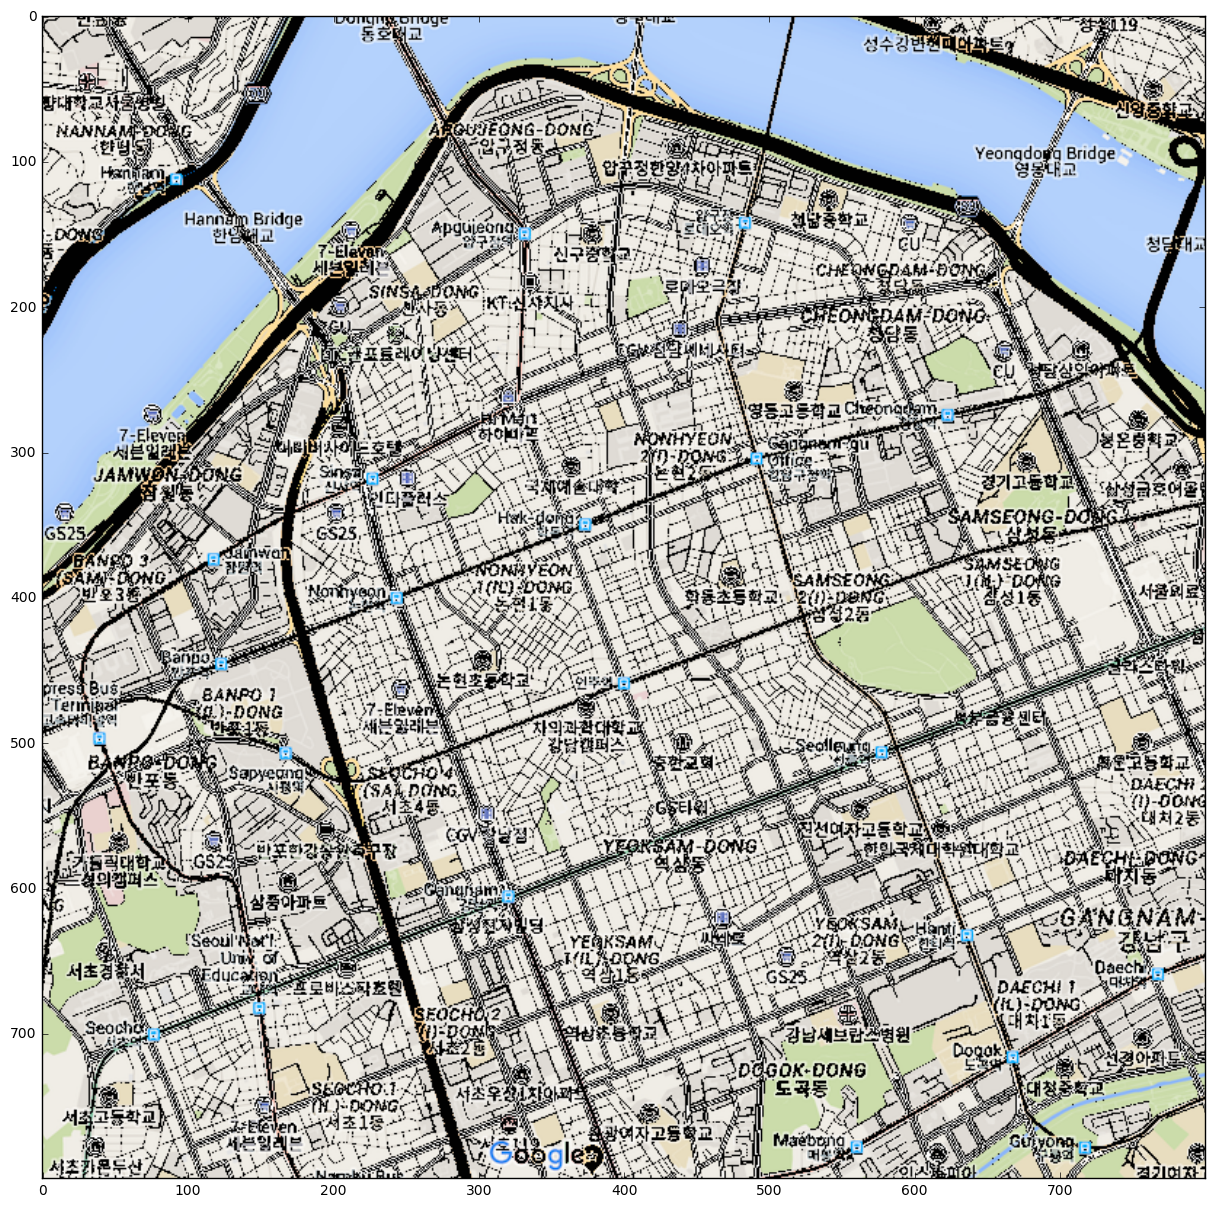

In [43]:
### Print weighted map ###
plt.figure(figsize=(15, 15))
t = plt.imshow(raw_data)

plt.show()



In [11]:
### Run a star algorithm ###

start = (0,0)
end = (700, 700)

greedy_res = greedy_search(start, end, weight_matrix, .000001)
a_res = a_star(start, end, weight_matrix)

result = print_shortest_path(start,end, a_res)

grredy_path = greedy_res['visited']
a_star_path = result['visited']

print 'Path costs:'
print result['cost']
print greedy_res['cost']

costs
4657184


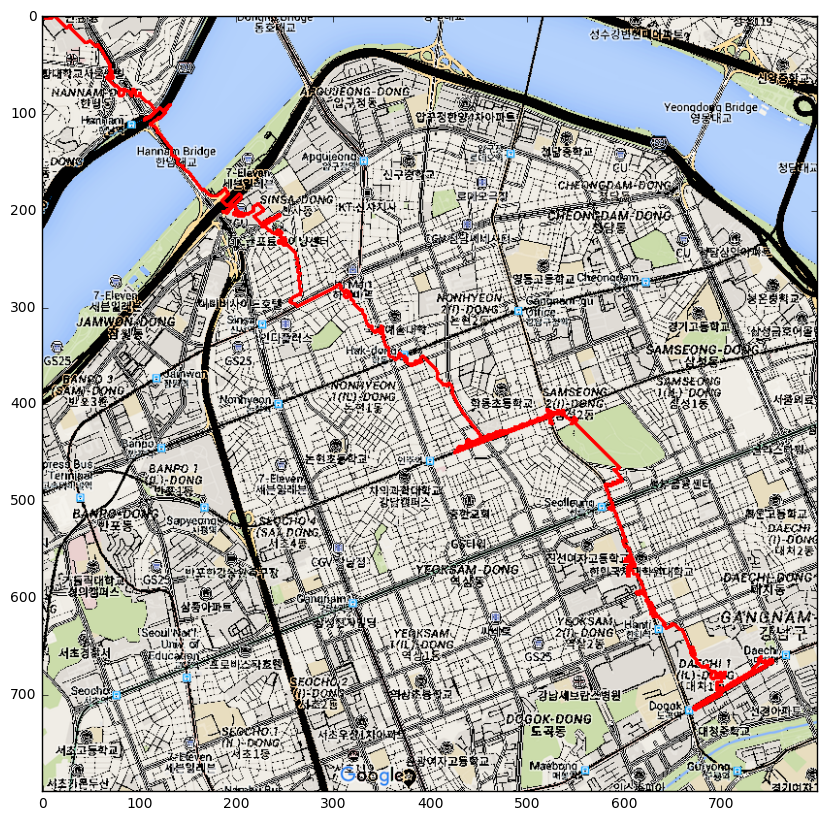

In [12]:
img_data = copy.deepcopy(raw_data)
print "Greedy path"

for step in grredy_path:
    img_data[step[0]][step[1]] = path_color
    neighbours = get_neighbors(step, size)
    for n in neighbours:
        img_data[n[0]][n[1]] = path_color
    
plt.figure(figsize=(10,10))
plt.imshow(img_data)
plt.show()



In [13]:
img_data = copy.deepcopy(raw_data)
print "A star path"

for step in a_star_path:
    img_data[step[0]][step[1]] = path_color
    neighbours = get_neighbors(step, size)
    for n in neighbours:
        img_data[n[0]][n[1]] = path_color
    
plt.figure(figsize=(10,10))
plt.imshow(img_data)
plt.show()




A star path
